# Temperature Prediction on the Jena Weather Dataset

## Applied Machine Learning (ICS-5110) Coursework

In this Jupyter Notebook, we will implement a **Naive Bayes** algorithm from first principles and use it to predict the temperature on the [Jena Weather Dataset](https://www.kaggle.com/datasets/mnassrib/jena-climate). 


The **Jena Weather Dataset** consists of weather data from the city of Jena, Germany, collected over a period of several years. It contains measurements such as temperature, air pressure, and humidity, as well as information regarding the date and time of each measurement. 

Our task is to perform **temperature prediction**. We will use measurements not directly associated with the temperature to predict the temperature at a specific date and time.

Besides training and testing our models, we will also determine the impact of some machine learning techniques on the performance of our model, including re-scaling and normalization, cross-validation, and feature selection. Additionally, we will also use Principal Component Analysis (PCA) to try to improve the precision of our model.

## Title Definition

### Global variables 

In this section we define global setup variables that will be used through the course of this notebook.

* **DROP_SET_THRESHOLD** is a number that represents the threshold for dropping a set of data from further analysis after feature selection.
* **PCA_THRESHOLD** is a number that represents the threshold for selecting the number of PCA components while iterating over the cumulative explained variance.
* **N_FOLDS** is a number that represents the number of folds to use in cross-validation, a technique used to evaluate the performance of a machine learning model.

To download your `kaggle.json` file from [Kaggle](http://kaggle.com/) and access the Kaggle API, follow these steps:

* Go to the Kaggle website and log in to your account.

* Click on your avatar in the top right corner of the page and select the "Account" option.

* Scroll down to the API section and click on the "Create New API Token" button. This will download the `kaggle.json` file to your computer.

In [ ]:
DROP_SET_THRESHOLD = 0.95
PCA_THRESHOLD = 0.95
N_FOLDS = 10

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import math
from typing import List, Dict, Tuple, Union, Optional, Any

## Get the Data

In [ ]:
!pip install opendatasets

     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=1315249c8ad1f9ac786028533c2de65c92374d2a26051dc493d8cccc4545e503
  Stored in directory: c:\users\ebube\appdata\local\pip\cache\wheels\ac\b2\c3\fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [ ]:
"""
{
    "username":"ikeebube",
    "key":"1c1385b10ccbe3472dfdec19144b46ba
}
"""

import opendatasets as od
od.download("https://www.kaggle.com/datasets/mnassrib/jena-climate")

Skipping, found downloaded files in ".\jena-climate" (use force=True to force download)


In [ ]:
dataset = pd.read_csv("jena-climate/jena_climate_2009_2016.csv")
dataset.index.name = 'Index'

dataset.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Index,,,,,,,,,,,,,,,
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
#Converting the temperature column from figures to a string

def convert_temperature(temp):
    if temp < 0:
        return "below_zero"
    if temp < 15:
        return "cold"
    if temp < 25:
        return "mild"
    return "hot"

dataset["T (degC)"] = dataset["T (degC)"].apply(convert_temperature)
dataset.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Index,,,,,,,,,,,,,,,
0,01.01.2009 00:10:00,996.52,below_zero,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,below_zero,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,below_zero,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,below_zero,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,below_zero,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Exploratory Data Analysis

The columns `"T (degC)"`, `"Tpot (K)"`, and `"Tdew (degC)"` represent the temperature in degrees Celsius, the potential temperature in Kelvin, and the dew point temperature in degrees Celsius, respectively. Since temperature can be represented in different units, these columns represent the same physical quantity (temperature).

Since these columns are redundant and represent the same thing as the `"T (degC)"` column, we must drop them from the dataset to avoid data leakage.

In [ ]:
dataset.drop("Tpot (K)", axis=1, inplace=True)
dataset.drop("Tdew (degC)", axis=1, inplace=True)

### Convert date and time strings

We define a function that converts date and time strings to timestamps, days of the year, and seconds since midnight. This will capture all three time factors that can affect the temperature at a given point: the date, the season, and the time of the day.

In [ ]:
def convert_to_timestamp(date):
  dt_object = datetime.strptime(date, '%d.%m.%Y %H:%M:%S')
  seconds_since_midnight = dt_object.hour * 60 * 60 + dt_object.minute * 60 + dt_object.second
  return dt_object.timestamp(), dt_object.timetuple().tm_yday, seconds_since_midnight

dataset[["timestamp", "year_day", "seconds"]] = list(dataset["Date Time"].apply(convert_to_timestamp))
dataset.drop("Date Time", inplace=True, axis=1)
dataset

,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),timestamp,year_day,seconds
Index,,,,,,,,,,,,,,,
0,996.52,below_zero,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1.230765e+09,1.0,600.0
1,996.57,below_zero,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1.230766e+09,1.0,1200.0
2,996.53,below_zero,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,1.230766e+09,1.0,1800.0
3,996.51,below_zero,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,1.230767e+09,1.0,2400.0
4,996.51,below_zero,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,1.230767e+09,1.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,1000.07,below_zero,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,1.483223e+09,366.0,84000.0
420547,999.93,below_zero,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,1.483223e+09,366.0,84600.0
420548,999.82,below_zero,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,1.483224e+09,366.0,85200.0


## Define data splits

We split the data into two parts, one for training and development and one for testing.

Then we use a factory to create a nested dictionary structure to store the data from the DataFrame, where the training and development data and the testing data are stored in different keys, and the raw data and processed data are stored in different subkeys.

In [ ]:
from collections import defaultdict

def factory(): return defaultdict(factory)
data = factory()

test = dataset.tail(int(len(dataset) * 0.2))
df = dataset.head(int(len(dataset) * 0.8))

data["test"]["raw"]["y"]["ndarray"] = test["T (degC)"].to_numpy()
data["test"]["raw"]["y"]["columns"] = list(test[["T (degC)"]].columns)

data["train+dev"]["raw"]["y"]["ndarray"] = df["T (degC)"].to_numpy()
data["train+dev"]["raw"]["y"]["columns"] = list(df[["T (degC)"]].columns)

df.drop("T (degC)", inplace=True, axis=1)
test.drop("T (degC)", inplace=True, axis=1)

df_X = df.to_numpy()
data["test"]["raw"]["x"]["ndarray"] = test.to_numpy()
data["test"]["raw"]["x"]["columns"] = list(test.columns)

data["train+dev"]["raw"]["x"]["ndarray"] = df.to_numpy()
data["train+dev"]["raw"]["x"]["columns"] = list(df.columns)

C:\Users\ebube\AppData\Local\Temp\ipykernel_7100\2794694871.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("T (degC)", inplace=True, axis=1)
C:\Users\ebube\AppData\Local\Temp\ipykernel_7100\2794694871.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop("T (degC)", inplace=True, axis=1)


## Visualize the splits


Here we define `visualize_data` that takes a dictionary as input and prints a representation of it in JSON format. The representation replaces the values of each key with the length of the value if it is not a string, and recursively processes nested dictionaries. The resulting dictionary is printed in JSON format.

In [ ]:
import yaml
import copy
import collections.abc
import json

def visualize_data(data: dict) -> str:
  def get_repr(data: dict) -> dict:
    for key, value in data.items():
      if isinstance(value, dict):
        # Recursively apply the function to nested dictionaries.
        data[key] = get_repr(value)
      elif not isinstance(value, str):
        try:
          # Replace the value with its length if possible.
          data[key] = len(value)
        except TypeError:
          # Do nothing if the value is not a sequence (i.e., it doesn't have a length).
          pass
    return data
  # Return a JSON representation of the data.
  return json.dumps(get_repr(copy.deepcopy(data)), indent=4)

print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 14
            }
        }
    }
}


## Feature Selection



Feature selection is a technique used to identify and select only the most relevant features from a dataset. This is useful because it reduces the dimensionality of the input data, which can improve the performance of machine learning models. Here we will perform feature selection using the filter method and the Pearson correlation coefficient. 

Our implementation of the Pearson correlation coefficient can be described by the formula:

$$ \rho = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}} $$

Where $x$ and $y$ are the input arrays and $\bar{x}$ and $\bar{y}$ are the means of the input arrays.

By calculating the Pearson correlation coefficient between all pairs of features, we can identify those that are highly correlated and might not provide any additional useful information for our model. These highly correlated features can then be removed, reducing the dimensionality of the input data and improving the performance of the model.

In [ ]:
def pearson_correlation(a: np.ndarray, b: np.ndarray) -> float:
    # Normalize the input arrays.
    norm_a = a - a.mean()
    norm_b = b - b.mean()
    # Compute the squared norms of the input arrays.
    squared_norm_a = norm_a ** 2
    squared_norm_b = norm_b ** 2
    # Compute the dot product of the normalized input arrays.
    dot_product_a_b = norm_a * norm_b
    # Compute the Pearson correlation coefficient.
    p_value = dot_product_a_b.sum() / np.sqrt(squared_norm_a.sum() * squared_norm_b.sum())
    return p_value

def get_corr_matrix(x: np.ndarray) -> np.ndarray:
  # Initialize the correlation matrix with zeros.
  corr_matrix = np.zeros((x.shape[1], x.shape[1]))
  # Get the upper triangle indices of the correlation matrix.
  i_indices, j_indices = np.triu_indices(x.shape[1])
  # Transpose the input data. Each column will become a row.
  x_t = x.T
  for k in range(len(i_indices)):
    i = i_indices[k]
    j = j_indices[k]
    if i == j:
      # Skip the diagonal.
      continue
    # Get the ith and jth columns of the transposed input data.
    a = x_t[i]
    b = x_t[j]
    # Compute the Pearson correlation coefficient for the ith and jth columns.
    corr_matrix[i][j] = pearson_correlation(a,b)
  return corr_matrix

def get_drop_set(labels: List[str], corr_matrix: np.ndarray, threshold: float = 0.95) -> Tuple[List[str], List[int]]:
  # Compute the absolute value of the correlation matrix.
  abs_corr_matrix = np.absolute(corr_matrix)
  # Zip the indices and values of the columns with a correlation coefficient greater than the threshold.
  drop_set = [(index, item) for index, item in enumerate(labels) if any(abs_corr_matrix[index] > threshold) ]
  # Unzip the list of tuples into two lists: the labels and the indices.
  drop_set_indices, drop_set_values = list(zip(*drop_set))
  return drop_set_values, drop_set_indices

In [ ]:
# Iterating over each dataset for train and test and
# dropping the columns not needed 
raw_columns = data["train+dev"]["raw"]["x"]["columns"]
raw_data = data["train+dev"]["raw"]["x"]["ndarray"]

corr_matrix = get_corr_matrix(raw_data)
drop_set_values, drop_set_indices = get_drop_set(raw_columns, corr_matrix, threshold=DROP_SET_THRESHOLD)
print(f"Dropped columns for train+dev : {drop_set_values}")

n_cols = data["train+dev"]["raw"]["x"]["ndarray"].shape[1]
mask = np.ones(n_cols).astype(bool)
mask[list(drop_set_indices)] = False

for dataset in ["train+dev", "test"]:
    data[dataset]["fs"]["x"]["ndarray"] = data[dataset]["raw"]["x"]["ndarray"][:, mask]
    data[dataset]["fs"]["x"]["columns"] = [x for x in raw_columns if x not in drop_set_values]
    data[dataset]["fs"]["y"] = data[dataset]["raw"]["y"]

Dropped columns for train+dev : ('VPact (mbar)', 'sh (g/kg)', 'wv (m/s)')


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 336440,
                "columns": 11
            },
            "y": {
                "ndarray": 336440,
                "columns": 1
            }
        }
    }
}


## Rescaling and Normalization

Here we apply rescaling and normalization techniques to our training data. These preprocessing steps are essential for ensuring that the data is properly formatted and ready for principal component analysis (PCA), which we will perform in the next section.

The formulas for min-max scaling and mean normalization are implemented as follows:

$$\text{min max scaling}(arr) = \frac{arr - \text{min}(arr)}{\text{max}(arr) - \text{min}(arr)}$$

$$\text{mean normalisation}(arr) = \frac{arr - \text{mean}(arr)}{\text{max}(arr) - \text{min}(arr)}$$

In [ ]:
def min_max_scaled(arr: np.ndarray) -> np.ndarray:
  """
  Scales the elements of `arr` by their minimum and maximum values.
  
  This function scales the elements of a n-dimensional array `arr` by 
  the minimum and maximum values along each of its dimensions.
  
  Args:
    arr: The array to be scaled.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    by their minimum and maximum values.
  """
  return (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def mean_normalisation(arr: np.ndarray) -> np.ndarray:
  """
  Normalizes the elements of `arr` by their mean value.
  
  This function normalizes the elements of a n-dimensional array `arr` by
  the mean value along each of its dimensions.
  
  Args:
    arr: The array to be normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements normalized
    by their mean value.
  """
  return (arr - arr.mean(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def scale_and_normalize(arr: np.ndarray) -> np.ndarray:
  """
  Scales and normalizes the elements of `arr` by their minimum and maximum values.
  
  This function first scales the elements of `arr` by their minimum and maximum
  values, and then normalizes the scaled elements by their mean value.
  
  Args:
    arr: The array to be scaled and normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    and normalized as described above.
  """
  return mean_normalisation(min_max_scaled(arr))

In [ ]:
for dataset in data:
  raw_columns = data[dataset]["raw"]["x"]["columns"]
  raw_data = data[dataset]["raw"]["x"]["ndarray"]

  fs_columns = data[dataset]["fs"]["x"]["columns"]
  fs_data = data[dataset]["fs"]["x"]["ndarray"]
    
    #Data after normalisation

  data[dataset]["raw+norm"]["x"]["ndarray"] = scale_and_normalize(raw_data)
  data[dataset]["raw+norm"]["x"]["columns"] = raw_columns
  data[dataset]["raw+norm"]["y"] = data[dataset]["raw"]["y"]
    #Data after feature selection and normalization

  data[dataset]["fs+norm"]["x"]["ndarray"] = scale_and_normalize(fs_data)
  data[dataset]["fs+norm"]["x"]["columns"] = fs_columns
  data[dataset]["fs+norm"]["y"] = data[dataset]["fs"]["y"]

## PCA ( Principal Component Analysis )

PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset while retaining as much of the original information as possible. 

The `PCA` class below takes a dataset as input and computes its covariance matrix, eigenvalues, and eigenvectors. In PCA, the eigenvectors of the covariance matrix are the principal components, and the eigenvalues are the corresponding variances along each principal component.

Our implementation of `PCA` provides two methods: `project`, which projects the dataset onto the principal components, and `determine_components`, which determines the number of principal components required to explain a given threshold of variance in the data. 

Although here we are using PCA to reduce the number of features in our dataset, like other dimensionality reduction algorithms ( e.g. t-SNE ), it can also be used for visualizing high-dimensional data in lower dimensions.

In [ ]:
class PCA(object):
    def __init__(self,X):
      """
      Perform Principal Component Analysis on a given dataset.

      Args:
        X: 2D numpy array of the dataset.

      Returns:
        None.
      """
      self.X = X
      self.covariance_matrix = np.cov(X, rowvar=False)
      eigenvalues, eigenvectors = np.linalg.eigh(self.covariance_matrix)
      sorted_tuples = sorted(list(zip(eigenvalues, eigenvectors)), key=lambda x: x[0], reverse=True)
      eigenvalues, eigenvectors = list(zip(*sorted_tuples))
      eigenvectors = np.array([np.array(x) for x in eigenvectors]) 
      self.eigenvalues = eigenvalues
      self.eigenvalues_sum = sum(eigenvalues)
      self.eigenvectors = eigenvectors
      self.explained_variance = [ (x / self.eigenvalues_sum) for x in self.eigenvalues]
      self.cumulative_explained_variance = np.cumsum(self.explained_variance)
  
    def project(self, components=2):
      """Projects the dataset onto the given number of principal components.

      Args:
        components: The number of principal components to project the data onto.
          Default is 2.

      Returns:
        The projected dataset.
      """
      projection_matrix = self.eigenvectors[:components, :]
      return self.X.dot(projection_matrix.T)

    def determine_components(self, threshold=0.95):
      """Determines the number of principal components required to explain the given threshold of variance.

      Args:
        threshold: The required threshold of variance that must be explained. Default is 0.95.

      Returns:
        The number of principal components required to explain the given threshold of variance.
      """
      for idx, item in enumerate(self.cumulative_explained_variance):
        if item >= threshold:
          return idx + 1

In [ ]:
norm_datasets = []
for split in data:
  for dataset in data[split]:
    if dataset.endswith("norm"):
      norm_datasets.append((split, dataset))

for split, dataset in norm_datasets:
    norm_data = data[split][dataset]["x"]["ndarray"]
    norm_columns = data[split][dataset]["x"]["columns"]

    pca = PCA(norm_data)
    components = pca.determine_components(threshold=PCA_THRESHOLD)
    print(f"Components for split {split}, dataset {dataset}: {components}")
    X_projection = pca.project(components=components)
    print(components, pca.cumulative_explained_variance)

    new_dataset = dataset + "+" + "pca"
    data[split][new_dataset]["x"]["ndarray"] = X_projection
    data[split][new_dataset]["x"]["columns"] = list(range(X_projection.shape[1]))
    data[split][new_dataset]["y"] = data[split][dataset]["y"]

Components for split test, dataset raw+norm: 6
6 [0.31588912 0.49662957 0.66684758 0.7818695  0.88736488 0.96342753
 0.99259129 0.9981857  0.99915104 0.99997591 0.99999768 0.99999992
 0.99999999 1.        ]
Components for split test, dataset fs+norm: 6
6 [0.2726752  0.47520966 0.63782478 0.77018726 0.89256037 0.96045351
 0.99231487 0.99851002 0.99948189 0.99999972 1.        ]
Components for split train+dev, dataset raw+norm: 7
7 [0.24463383 0.4371378  0.60620335 0.74717062 0.86739694 0.94375047
 0.97912356 0.99331875 0.99797672 0.9991417  0.99999839 0.99999993
 0.99999999 1.        ]
Components for split train+dev, dataset fs+norm: 6
6 [0.2295924  0.44171455 0.63117002 0.76757864 0.9002248  0.95721192
 0.98068465 0.99396184 0.99886513 0.99999969 1.        ]


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 14
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "fs+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 11
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm+pca": {
            "x": {
                "ndarray": 84110,
         

## K-Fold Cross Validation


Here we implement **k-fold cross validation**. The original dataset is divided into k subsets, and the model is trained and evaluated k times in a leave-one-out fashion. 

Each time, one subset is used as the test set and the other subsets are used as the training set. Next we take statistical measurements over the performance across all k trials. 


**Why? K-Fold Cross Validation** Because it ensures that every observation from the original dataset has the chance of appearing in training and test set. This is one among the best approach if we have a limited input data. Although our dataset is not particularly small, k-fold cross validation will help us to portray a more accurate estimate of the model's performance. 

In [ ]:
import itertools
def generate_folds(X, k=10):
  """Generates k folds for cross-validation.

  Args:
    X: The dataset.
    k: The number of folds to generate.

  Returns:
    A tuple containing the train and dev datasets for each fold.
  """
  folds = []
  # The variable remainder is used to ensure that the folds of the dataset 
  # are evenly distributed and that no data is lost.
  remainder = len(X) % k
  step = len(X) // k
  start_pointer = 0
  next_step = step
  # Generate the folds.
  while start_pointer + next_step < len(X):
    if remainder:
      next_step += 1
      remainder -= 1
      folds.append(X[start_pointer:start_pointer+next_step])
      next_step -= 1
    else:
      folds.append(X[start_pointer:start_pointer+next_step])
    start_pointer += next_step
  # Generate the train and dev datasets for each fold.
  for idx in range(len(folds)):
    # The train dataset is the concatenation of all folds except the current fold.
    train = folds[0:idx] + folds[idx+1:len(folds)]
    train = np.array([x for y in train for x in y])
    train = np.array(train)
    # The dev dataset is the current fold.
    dev = np.array(folds[idx])
    yield train, dev

def get_all_folds(x, y, k=10):
  """Generates k folds for cross-validation for a dataset with features and labels.

  Args:
    x: The features of the dataset.
    y: The labels of the dataset.
    k: The number of folds to generate.

  Returns:
    A tuple containing the train features, train labels, dev features, and dev labels for each fold.
  """
  data = []
  # Concatenate the features and labels into a single dataset.
  x_y = np.append(x, y.reshape(-1, 1), axis=1)
  # Generate the train and dev datasets for each fold.
  for train, dev in generate_folds(x_y, k=k):
    # Split the train dataset into features and labels.
    train_x = np.delete(train, -1, axis=1)
    train_y = train[:, -1]
    # Split the dev dataset into features and labels.
    dev_x = np.delete(dev, -1, axis=1)
    dev_y = dev[:, -1]
    yield train_x.astype(np.float64), train_y, dev_x.astype(np.float64), dev_y

cross_validation_data = factory()
for split in data:
  for dataset in data[split]:
    x = data[split][dataset]["x"]["ndarray"]
    y = data[split][dataset]["y"]["ndarray"]
    x_cols = data[split][dataset]["x"]["columns"]
    y_cols = data[split][dataset]["y"]["columns"] 
    for idx, (train_x, train_y, dev_x, dev_y) in enumerate(get_all_folds(x, y, k=N_FOLDS)):
      cross_validation_data[split][dataset][idx]["train"]["x"]["ndarray"] = train_x
      cross_validation_data[split][dataset][idx]["train"]["x"]["columns"] = x_cols
      cross_validation_data[split][dataset][idx]["train"]["y"]["ndarray"] = train_y
      cross_validation_data[split][dataset][idx]["train"]["y"]["columns"] = y_cols

      cross_validation_data[split][dataset][idx]["validation"]["x"]["ndarray"] = dev_x
      cross_validation_data[split][dataset][idx]["validation"]["x"]["columns"] = x_cols
      cross_validation_data[split][dataset][idx]["validation"]["y"]["ndarray"] = dev_y
      cross_validation_data[split][dataset][idx]["validation"]["y"]["columns"] = y_cols

## Training and evaluation with `sklearn`

In this section we will define evaluation metrics and evaluation functions for our models. Furthermore, we will evaluate an out-of-the-box Naive Bayes model from the `sklearn` library.

## Define evaluation metrics

In this section we define appropriate evaluation metrics for the problem of temperature prediction, which is a classification task. We will utilize the **accuracy metric** as a measure of the difference between the predicted values and the true values.


Our implementation of the Accuracy metric can be defined by the formula:

$$\text{Accuracy} = \frac{TN + TP}{TN + FP + TP + FN}$$

where:
* $TP$ : True Positives i.e. positive classes that are correctly predicted as positive.
* $FP$ : False Positives i.e negative classes that are falsely predicted as positive.
* $TN$ : True Negatives i.e. negative classes that are correctly predicted as negative.
* $FN$ : False Negatives i.e positive classes that are falsely predicted as negative.

In [ ]:
def accuracy(a: np.ndarray, b: np.ndarray) -> float:
    return np.sum(a == b) / len(a)

def evaluate_classification(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
  return {
      "accuracy": accuracy(y_true, y_pred),
  }

def generate_cross_validation_chart(metrics: dict) -> pd.DataFrame:
  return pd.DataFrame(metrics).agg(
      {
          "accuracy": ["mean", "std", "median"],})

## Evaluation functions

In [ ]:
from sklearn.naive_bayes import GaussianNB
from tqdm.notebook import tqdm

def test_model(model, data: Dict[str, Any], metadata: Dict[str, Any], 
               train_split: str="train+dev", test_split: str="test", 
               dataset: str="raw", sample: int=None, build: bool=False) -> Dict[str, Any]:
  """Tests the model on a dataset and returns the evaluation metrics and predictions.

  Args:
    model: The model to test. The model should be wrapped inside an anonymous function.
    data: A dictionary containing the data to use for testing.
    metadata: A dictionary containing metadata about the data.
    train_split: The name of the train split to use. Defaults to "train+dev".
    test_split: The name of the test split to use. Defaults to "test".
    dataset: The name of the dataset to use. Defaults to "raw".
    sample: The number of samples to use for testing. Defaults to None, which means use all samples.

  Returns:
    A dictionary containing the evaluation metrics, predictions, and labels.
  """
  df = []
  iterator = []

  train_X = data[train_split][dataset]["x"]["ndarray"]
  train_X_cols = data[train_split][dataset]["x"]["columns"]

  train_Y = data[train_split][dataset]["y"]["ndarray"]
  train_Y_cols = data[train_split][dataset]["y"]["columns"] 

  test_X = data[test_split][dataset]["x"]["ndarray"]
  test_X_cols = data[test_split][dataset]["x"]["columns"]

  test_Y = data[test_split][dataset]["y"]["ndarray"]
  test_Y_cols = data[test_split][dataset]["y"]["columns"]

  if build:
    train_X = pd.DataFrame(train_X, columns=train_X_cols)
    train_Y = pd.DataFrame(train_Y, columns=train_Y_cols)["T (degC)"]
    test_X = pd.DataFrame(test_X, columns=test_X_cols)
    test_Y = pd.DataFrame(test_Y, columns=test_Y_cols)["T (degC)"]

  # If a sample size is provided, use it to subsample the data
  if sample:
    get_sample = lambda a: a[range(0, len(a), len(a) // sample)]
    train_X = get_sample(train_X)
    train_Y = get_sample(train_Y)

  # Create and fit the model
  regr = model()
  regr.fit(train_X, train_Y)
  # Make predictions on the test data
  pred = regr.predict(test_X)
  # Evaluate the model using the evaluate_regression function
  m = evaluate_classification(test_Y, pred)

  # Return the evaluation metrics, predictions, and labels
  return {
      "metrics": m,
      "predictions": pred,
      "labels": test_Y
  }

def evaluate_cross_validation(model, cross_validation_data: Dict[str, Any], metadata: Dict[str, Any]):
  """Evaluates the model using cross-validation.

  Args:
    model: The model to evaluate.
    cross_validation_data: A dictionary containing the cross-validation data.
    metadata: A dictionary containing metadata about the model.

  Returns:
    A pandas DataFrame containing the evaluation metrics for each split and dataset.
  """
  df = []
  iterator = []
  # Create an iterator that will iterate over all splits, datasets, and indices
  for split in cross_validation_data:
    for dataset in cross_validation_data[split]:
      for idx in cross_validation_data[split][dataset]:
        iterator.append((split, dataset, idx))
  
  for split, dataset, idx in tqdm(iterator):
    d = cross_validation_data[split][dataset][idx]
    
    # Get train and validation data
    train_X = d["train"]["x"]["ndarray"]
    train_Y = d["train"]["y"]["ndarray"]
    validation_X = d["validation"]["x"]["ndarray"]
    validation_Y = d["validation"]["y"]["ndarray"]
    
    # Train the model
    regr = model()
    regr.fit(train_X, train_Y)

    # Evaluate the model
    pred = regr.predict(validation_X)
    m = evaluate_classification(validation_Y, pred)
    acc = m["accuracy"]

    # Save the results
    row = {
        "split": split,
        "dataset": dataset,
        "idx": idx,
        "accuracy": acc,
    }
    row.update(metadata)
    df.append(row)

  return pd.DataFrame(df)

## Evaluate with k-fold cross-validation

### Execution

In this section we will perform a preliminary evaluation of an out-of-the box implementation of GaussianNB by `sklearn`. We will evaluate it on our dataset under a few distinct scenarios:

* **raw**: the original training data.
* **fs+norm**: the training data after feature selection and normalisation.
* **fs+norm+pca**: the training data after feature selection, normalisation and PCA.
* **raw+norm**: the training data after normalisation.
* **raw+norm+pca**: the training data after normalisation and PCA.

In [ ]:
metadata = dict(var_smoothing=1e-9)
get_gaussian = lambda: GaussianNB(**metadata)
cross_validation_metrics_df = evaluate_cross_validation(get_gaussian, cross_validation_data, metadata)
cross_validation_metrics_df.head()

  0%|          | 0/108 [00:00<?, ?it/s]

,split,dataset,idx,accuracy,var_smoothing
0,test,raw,0,0.356795,1.000000e-09
1,test,raw,1,0.285935,1.000000e-09
2,test,raw,2,0.856260,1.000000e-09
3,test,raw,3,0.827844,1.000000e-09
4,test,raw,4,0.727143,1.000000e-09


In [ ]:
cross_validation_metrics_df.to_csv("cross_validation_metrics.csv")

mask = cross_validation_metrics_df["split"] == "train+dev"
final_metrics_df = cross_validation_metrics_df[mask][["dataset", "accuracy",]].groupby(by=["dataset"]).agg(
      {
          "accuracy": ["mean", "std", "median"],}).round(3)

### Evaluation Results

The measurements show that feature selection alone, had no effect on the performance of our model. However, Steps like normalization, on the other hand, had a significant impact on the model's performance, and when combined with feature selection, had an improved impact. This is because Gaussian Naive Bayes assumes that each parameter feature can predict the output variable independently.

In [ ]:
final_metrics_df

accuracy              
                 mean    std median
dataset                            
fs              0.580  0.052  0.597
fs+norm         0.918  0.012  0.922
fs+norm+pca     0.844  0.038  0.847
raw             0.580  0.052  0.597
raw+norm        0.905  0.012  0.910
raw+norm+pca    0.843  0.032  0.843

In [ ]:
print(final_metrics_df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{accuracy} \\
{} &     mean &    std & median \\
dataset      &          &        &        \\
\midrule
fs           &    0.580 &  0.052 &  0.597 \\
fs+norm      &    0.918 &  0.012 &  0.922 \\
fs+norm+pca  &    0.844 &  0.038 &  0.847 \\
raw          &    0.580 &  0.052 &  0.597 \\
raw+norm     &    0.905 &  0.012 &  0.910 \\
raw+norm+pca &    0.843 &  0.032 &  0.843 \\
\bottomrule
\end{tabular}



C:\Users\ebube\AppData\Local\Temp\ipykernel_7100\447280241.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(final_metrics_df.to_latex())


## Testing

In this section we evaluate an out-of-the box implementation of Naive Bayes on our test set.

The GaussianNB (Naive Bayes) implementation by `sklearn` was able to reach a accuracy of **0.7867554393056712** on our test set.

In [ ]:
metadata = dict(var_smoothing=1e-9)
get_gaussian = lambda: GaussianNB(**metadata)
output = test_model(get_gaussian, data, metadata, train_split="train+dev", test_split="test", dataset="fs+norm")
output

{'metrics': {'accuracy': 0.7867554393056712},
 'predictions': array(['mild', 'mild', 'mild', ..., 'below_zero', 'below_zero',
        'below_zero'], dtype='<U10'),
 'labels': array(['mild', 'mild', 'mild', ..., 'below_zero', 'below_zero',
        'below_zero'], dtype=object)}

In [ ]:
# We convert the labels into numbers, to build a heatmap 

import copy
temp_dict = {
    "below_zero": 0,
    "cold": 1,
    "mild": 2,
    "hot": 3
}

vis_output = copy.deepcopy(output)
vis_output["predictions"] = np.array([temp_dict[x] for x in vis_output["predictions"]]).astype(np.float64)
vis_output["labels"] = np.array([temp_dict[x] for x in vis_output["labels"]]).astype(np.float64)

## Visualization

At the end of this section, we produce a visualization of our predictions and put them side by side with the actual temperatures.

### Code

In [ ]:
def reshape_1d_array_with_padding(arr: np.ndarray, wrap: int=500) -> np.ndarray:
  """Reshape a 1D numpy array by adding padding to the end so that its length is a multiple of `wrap`.
  
  Args:
      arr (np.ndarray): The 1D array to be reshaped.
      wrap (int): The length of the subarrays that the reshaped array will be split into.
  
  Returns:
      np.ndarray: The reshaped array, with padding added to the end.
  """

  # Get the length of the original array
  old_len = arr.shape[0]

  # Calculate the length of the reshaped array
  new_len = wrap * math.ceil(old_len / wrap)
  
  # Add padding to the end of the array
  padded_arr = np.pad(arr, (0, new_len - old_len), 'constant')
  
  # Reshape the array into subarrays of length `wrap`
  padded_arr = padded_arr.reshape((-1, wrap))
  
  # Return the transpose of the reshaped array
  return padded_arr.T

In [ ]:
def plot_results(output: Dict[str, Any]) -> None:
  """
  Plots heatmaps of the given labels and predictions using seaborn.

  Args:
    output (dict): a dictionary containing "labels" and "predictions" keys
      whose values are 2-dimensional arrays to be plotted as heatmaps.

  Returns:
    None
  """
  plt.rcParams['figure.figsize'] = [15, 5]
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  ax = fig.add_subplot(1, 2, 1)
  fig_1 = sns.heatmap(reshape_1d_array_with_padding(output["labels"].copy()), cmap="coolwarm", vmin=min(output["labels"]), vmax=max(output["labels"]), cbar=False)
  fig_1.axis('off')
  ax = fig.add_subplot(1, 2, 2)
  fig_2 = sns.heatmap(reshape_1d_array_with_padding(output["predictions"].copy()), cmap="coolwarm", vmin=min(output["labels"]), vmax=max(output["labels"]), cbar=False)
  fig_2.axis('off')

### Plot

The figure on the left illustrates the recorded temperatures over time, while the figure on the right displays our predictions for the same time frame. Both figures use a color-coding system to represent different temperature ranges:

* Blue stripes represent below-zero degree weather
* Various shades of blue depict cold weather 
* Pink stripes indicate mild weather 
* Solid red stripes represent hot weather

Upon examination, it is apparent that the figure on the right has a higher frequency of dark blue stripes, indicating that we have predicted an increase in below-zero degree weather.

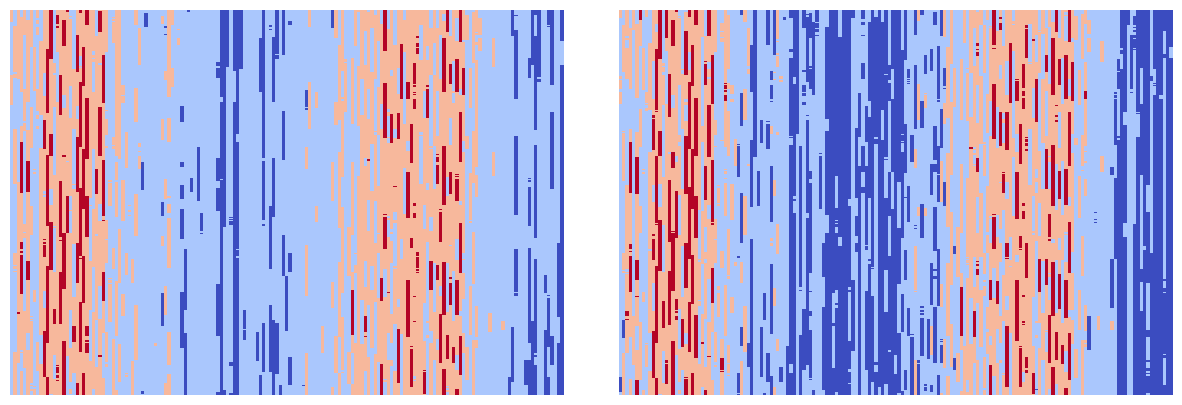

In [ ]:
plot_results(vis_output)

# Model development

In this section we will develop and evaluate our own Naive Bayes model. 

## Naive Bayes 


Bayes’ theorem describes the probability of an event, based on prior knowledge of conditions that might be related to the event. Our implementation of the Naive Bayes theorem, can be defined by the following: 
 ***P(A|B) = P(B|A) * P(A) / P(B)***

Applying Bayes Theorem Equation in Algorithm
Let’s break down our equation and understand how it works:

* ***P(A|B)*** is the posterior probability of class (target) given predictor (attribute).
* ***P(B)*** is the prior probability of class.
* ***P(B|A)*** is the likelihood which is the probability of predictor given class.
* ***P(A)*** is the prior probability of predictor.

In [ ]:
#From the raw dataset

__Xtrainlabel__ = data["train+dev"]["raw"]["x"]["columns"]
__ytrainlabel__ = data["train+dev"]["raw"]["y"]["columns"]
__Xtrain__ = data["train+dev"]["raw"]["x"]["ndarray"]
__ytrain__ = data["train+dev"]["raw"]["y"]["ndarray"]

In [ ]:
df_xtrain = pd.DataFrame(__Xtrain__, columns = __Xtrainlabel__)
df_ytrain = pd.DataFrame(__ytrain__, columns = __ytrainlabel__)
df_combined_train = pd.concat([df_xtrain, df_ytrain], axis=1)

In [ ]:
df_ytrain["T (degC)"]

0         below_zero
1         below_zero
2         below_zero
3         below_zero
4         below_zero
             ...    
336435          mild
336436          mild
336437          mild
336438          mild
336439          mild
Name: T (degC), Length: 336440, dtype: object

In [ ]:
# calculate mean, variance for each column and convert to numpy array
class NaiveBayesClassifier():
    '''
    Bayes Theorem form
    P(y|X) = P(X|y) * P(y) / P(X)
    '''
    def calc_prior(self, features, target):
        '''
        prior probability P(y)
        calculate prior probabilities
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()
        return self.prior
    
    def calc_mean_var(self, dataset, targ):
        self.mean = dataset.groupby(targ).apply(np.mean).to_numpy()
        self.var = dataset.groupby(targ).apply(np.var).to_numpy()

        return self.mean, self.var
    
    '''
    Next, let’s convert Gaussian density function to code:

    The formula for Gaussian Density function, derived from Wikipedia, looks like this: 
    (1/√2pi*σ) * exp((-1/2)*((x-μ)²)/(2*σ²)), 
    
    where μ is mean, σ² is variance, σ is square root of variance (standard deviation).
    
    '''
    
    def gaussian_density(self, class_idx, x):     
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        prob = numerator / denominator
        return prob
    
    '''
    The last step is to calculate prior and posterior probabilities:
    '''

    def calc_prior(self, features, targ):
        self.prior = (features.groupby(targ).apply(lambda x: len(x))/self.rows).to_numpy()
        return self.prior
    
    def calc_posterior(self, x):
        posteriors = []
        for i in range(self.count):
            prior = np.log(self.prior[i]) 
            conditional = np.sum(np.log(self.gaussian_density(i, x)))
            posterior = prior + conditional
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]
        
    '''
    Making Predictions:
    Finally, all the helper methods are now ready to use them in fit and predict methods:
    '''

    def fit(self, features, targ):
        # define class variables 
        self.classes = np.unique(targ)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        # calculate statistics    
        self.calc_mean_var(features, targ)
        self.calc_prior(features, targ)
        
    def predict(self, features):
        preds = [self.calc_posterior(f) for f in features.to_numpy()]
        return preds

## Model Evaluation

In [ ]:
x = NaiveBayesClassifier()
x.fit(df_xtrain, df_ytrain["T (degC)"])

x.classes, x.feature_nums, x.rows, x.count

C:\Users\ebube\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array(['below_zero', 'cold', 'hot', 'mild'], dtype=object), 14, 336440, 4)

In [ ]:
x.calc_prior(df_xtrain, df_ytrain["T (degC)"])

array([0.14793425, 0.59898347, 0.02491083, 0.22817144])

In [ ]:
x.calc_mean_var(df_xtrain, df_ytrain["T (degC)"])

C:\Users\ebube\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([[9.90037244e+02, 8.62585542e+01, 4.66402724e+00, 4.03439372e+00,
         6.29638143e-01, 2.54053465e+00, 4.07769062e+00, 1.27994867e+03,
         1.95242450e+00, 3.06527837e+00, 1.38581392e+02, 1.31551509e+09,
         1.23809548e+02, 3.87222961e+04],
        [9.88533915e+02, 7.97584109e+01, 1.09157999e+01, 8.59724204e+00,
         2.31840926e+00, 5.42927904e+00, 8.69736585e+00, 1.22233909e+03,
         2.11732610e+00, 3.51662335e+00, 1.84975133e+02, 1.33526279e+09,
         1.81114806e+02, 4.09708875e+04],
        [9.87512559e+02, 4.45930712e+01, 3.74339088e+01, 1.64825248e+01,
         2.09511407e+01, 1.04512552e+01, 1.66927550e+01, 1.13638789e+03,
         2.70220499e+00, 4.54698127e+00, 1.42319844e+02, 1.33135653e+09,
         1.99007398e+02, 5.48690371e+04],
        [9.88980399e+02, 6.38090350e+01, 2.19555588e+01, 1.37602809e+01,
         8.19530521e+00, 8.70475289e+00, 1.39169614e+01, 1.17406044e+03,
         2.30382305e+00, 3.87629523e+00, 1.72344489e+02, 1.33250770e+09

In [ ]:
x.mean, x.var

(array([[9.90037244e+02, 8.62585542e+01, 4.66402724e+00, 4.03439372e+00,
         6.29638143e-01, 2.54053465e+00, 4.07769062e+00, 1.27994867e+03,
         1.95242450e+00, 3.06527837e+00, 1.38581392e+02, 1.31551509e+09,
         1.23809548e+02, 3.87222961e+04],
        [9.88533915e+02, 7.97584109e+01, 1.09157999e+01, 8.59724204e+00,
         2.31840926e+00, 5.42927904e+00, 8.69736585e+00, 1.22233909e+03,
         2.11732610e+00, 3.51662335e+00, 1.84975133e+02, 1.33526279e+09,
         1.81114806e+02, 4.09708875e+04],
        [9.87512559e+02, 4.45930712e+01, 3.74339088e+01, 1.64825248e+01,
         2.09511407e+01, 1.04512552e+01, 1.66927550e+01, 1.13638789e+03,
         2.70220499e+00, 4.54698127e+00, 1.42319844e+02, 1.33135653e+09,
         1.99007398e+02, 5.48690371e+04],
        [9.88980399e+02, 6.38090350e+01, 2.19555588e+01, 1.37602809e+01,
         8.19530521e+00, 8.70475289e+00, 1.39169614e+01, 1.17406044e+03,
         2.30382305e+00, 3.87629523e+00, 1.72344489e+02, 1.33250770e+09

In [ ]:
__Xtestlabel__ = data["test"]["raw"]["x"]["columns"]
__ytestlabel__ = data["test"]["raw"]["y"]["columns"]
__Xtest__ = data["test"]["raw"]["x"]["ndarray"]
__ytest__ = data["test"]["raw"]["y"]["ndarray"]

In [ ]:
data["test"]["raw"]["y"]["ndarray"]

array(['mild', 'mild', 'mild', ..., 'below_zero', 'below_zero',
       'below_zero'], dtype=object)

In [ ]:
df_xtest = pd.DataFrame(__Xtest__, columns = __Xtestlabel__)
df_ytest = pd.DataFrame(__ytest__, columns = __ytestlabel__)
df_combined_train = pd.concat([df_xtest, df_ytest], axis=1)

In [ ]:
df_ytest["T (degC)"]

0              mild
1              mild
2              mild
3              mild
4              mild
            ...    
84105    below_zero
84106    below_zero
84107    below_zero
84108    below_zero
84109    below_zero
Name: T (degC), Length: 84110, dtype: object

In [ ]:
predictions = x.predict(df_xtest)

C:\Users\ebube\AppData\Local\Temp\ipykernel_7100\1864647703.py:51: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_density(i, x)))


### Accuracy

Our implementation of Naive Bayes on the raw dataset was able to reach an accuracy of **0.89513732017596**.   

This is notably better than the previous accuracy reached by the `sklean` solution under similar hyperparameters, at **0.7867554393056712**

In [ ]:
# To calculate accuracy
def accuracy(ytest, ypred) -> float:
    accuracy = np.sum(ytest == ypred) / len(ytest)
    return accuracy

In [ ]:
accuracy(df_ytest["T (degC)"], predictions)

0.89513732017596

In [ ]:
df_ytest["T (degC)"].value_counts(normalize=True)

cold          0.592450
mild          0.283569
below_zero    0.072120
hot           0.051861
Name: T (degC), dtype: float64

In [ ]:
metadata = dict()
get_gaussian = lambda: NaiveBayesClassifier(**metadata)
output = test_model(get_gaussian, data, metadata, train_split="train+dev", test_split="test", dataset="raw", build=True)
output

C:\Users\ebube\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\ebube\AppData\Local\Temp\ipykernel_7100\1864647703.py:51: RuntimeWarning: divide by zero encountered in log
  conditional = np.sum(np.log(self.gaussian_density(i, x)))


{'metrics': {'accuracy': 0.89513732017596},
 'predictions': ['mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'cold',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
  'mild',
 

In [ ]:
import copy
temp_dict = {
    "below_zero": 0,
    "cold": 1,
    "mild": 2,
    "hot": 3
}

vis_output = copy.deepcopy(output)
vis_output["predictions"] = np.array([temp_dict[x] for x in vis_output["predictions"]]).astype(np.float64)
vis_output["labels"] = np.array([temp_dict[x] for x in vis_output["labels"]]).astype(np.float64)

### Visualization

The figure on the left illustrates the recorded temperatures over time, while the figure on the right displays our predictions for the same time frame. Both figures use a color-coding system to represent different temperature ranges:

* Blue stripes represent below-zero degree weather
* Various shades of blue depict cold weather 
* Pink stripes indicate mild weather 
* Solid red stripes represent hot weather

Examining the figures, it is clear that they are virtually identical, indicating that our model has outperformed the Sklearn library.

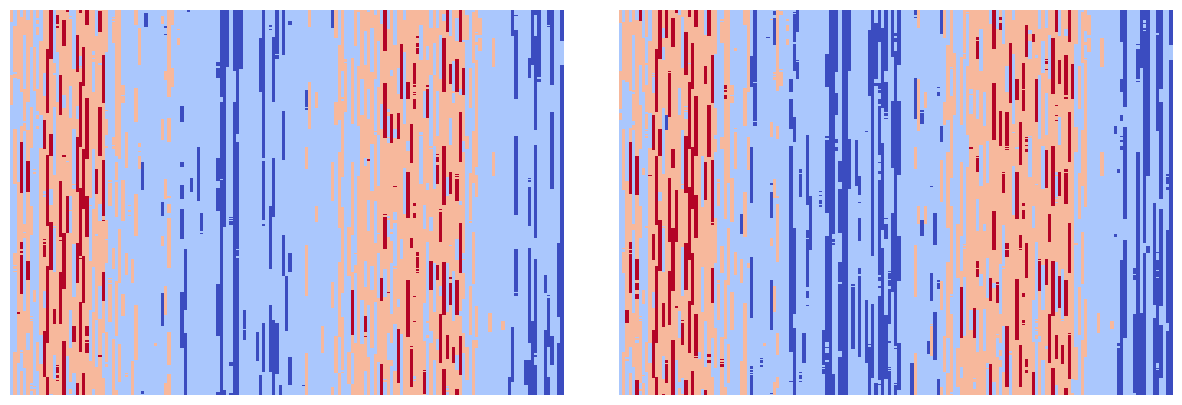

In [ ]:
plot_results(vis_output)

## Conclusion

Our analysis showed that feature selection alone has little to no impact on the **accuracy** of the model predictions

Whereas, our implementation of normalization had a huge positive impact on the model performance and had significant improvment with the addition of feature selection. 

Finally, our implementation of Naive Bayes outperformed the `sklearn` library on the raw data, but performed less with the data gotten from the implementation of fs+norm (feature selection + normalization). This may be due to the complex optimizations implemented in `sklearn`. Overall, our results matched the quality of third-party libraries.